# The interplay between PVE and resampling  

In [1]:
%load_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from matplotlib.cm import get_cmap
import os.path as op 
from prepare_data import SIM_ROOT, REAL_ROOT, N_REPEATS
from helpers import load_basil, load_lr, load_oxasl, load_oxasl_lr
from scipy.ndimage import binary_erosion
from scipy import stats 

cmap = np.array(get_cmap('tab10').colors)
loadnii = lambda p: nibabel.load(str(p)).get_fdata()

Instructions for updating:
non-resource variables are not supported in the long term


## Simulated data with low noise

Simulate ASL data with flat CBF and a relatively low amount of noise. The ASL data has 5 PLDs of 8 repeats each (40 label-control pairs). Reference CBF and ATT values of 60 / 1.3, 20 / 1.6 are used for GM and WM respectively. 

In [2]:
mask = loadnii(SIM_ROOT / 'mask.nii.gz').astype(np.bool)
pvs = loadnii(SIM_ROOT / 'tob_all_stacked_3.0.nii.gz')[...,:2]
wmmask = (pvs[...,1] > 0.05)
gmmask = (pvs[...,0] > 0.05)

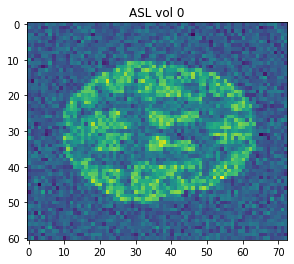

In [3]:
asl = nibabel.load(str(SIM_ROOT / 'asl_native.nii.gz')).get_fdata()
plt.imshow(asl[...,28,0])
plt.title('ASL vol 0')
plt.show()

### Resampling introduces PVE

Even without performing PVEc, resampling increases PVE within data by signal between tissue classes. This adds extra confound to the data. In order to demonstrate this, we generate a random affine transform, and then perform a round-trip on the data: 

Data -----> forward transform -----> data transformed ------> reverse transform ------> data double transformed, in alignment with ground truth. 

After the round trip, we theoretically have recovered the original data and therefore the CBF analysis should give the same results (especially because CBF is constant in both tissue classes). In practice, we have degraded the data by adding extra PVE and this is readily observed. 

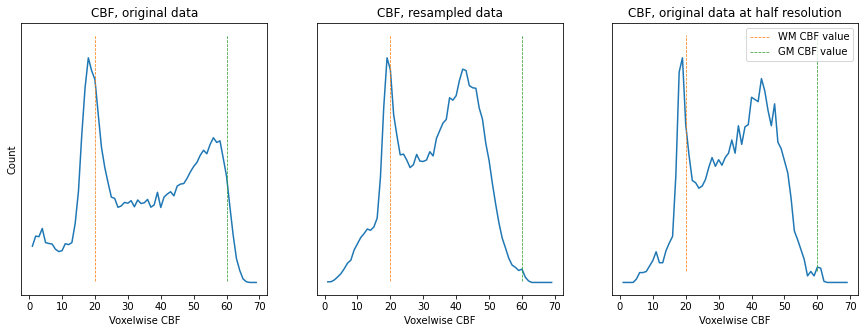

In [4]:
basil_native = load_basil(SIM_ROOT / 'basil_native', False)
basil_resamp = load_basil(SIM_ROOT / 'basil_double_resampled', False)
basil_half = rt.application_helpers.sum_array_blocks(basil_native[:-1,:-1,:-1], [2,2,2]) / 8
mask_half = (rt.application_helpers.sum_array_blocks(mask[:-1,:-1,:-1], [2,2,2]) / 8) > 0.5

bins = np.arange(0,70,1)
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, data, m, title in zip(axes, [basil_native, basil_resamp, basil_half], [mask, mask, mask_half],
                           ['CBF, original data', 'CBF, resampled data', 'CBF, original data at half resolution']):
    hist,_ = np.histogram(data[m], bins)
    ax.plot(bins[1:], hist)
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
    ax.plot([20,20], [10, 1.1 *hist.max()], '--', linewidth=0.75, label='WM CBF value')
    ax.plot([60,60], [10, 1.1 *hist.max()], '--', linewidth=0.75, label='GM CBF value')

    
ax.legend()
axes[0].set_ylabel('Count')
plt.show()

On the LHS we have the CBF from native data. The ground truth CBF values for GM and WM are shown with dashed lines. Though there is clearly a lot of PVE, we can see an underlying bimodal distribution with peaks at 20 and 60 units. 

On the central plot, the resampled data shows the two peaks of the bimodal distribution have converged. The peak at 20 is significantly reduced; the peak at 60 has shifted to around 45. This is exactly the same result as would be obtained if the original data simply had higher PVE (ie, larger voxels). 

On the RHS, the original data has been resampled to half resolution (double voxel size in each dimension). The effect is essentially indistinguishable from the central plot; resampling alters the underlying distribution of data in the same way as reducing spatial resolution. 

### Can PVEc undo the damage of resampling?

Resampling increases PVE, and PVEc may not be able to fully correct for this. Continuing with the same schema above (ASL data that has been through a round-trip of resampling), we now investigate PVEc of data that has been corrupted in this way. 

There are two strategies: 
1. PVEc with the original PVs (ie, the 'anatomical ground truth'). This is justified because the data hasn't technically moved out of alignment with the underlying PV estimates from which it was generated; if we are concerned only with finding the anatomically correct PVs caused by the intersection of the patient with the imaging matrix, then this is the strategy to use. We call this the *naive* approach 
2. PVEc with PVs that have undergone the same processing as the data itself (ie, the 'double resampled'). This is justified because the original distribution of PVE within the data has been altered by resampling; if we would like to correct for this, we need to know how the data has been corrputed. Resampling the PV estimates allows us to convey this information to the correction method. This is the *double resampling* approach. 

Both FABBER and the linear regression operating on the ASL data (LR on data) are used. 

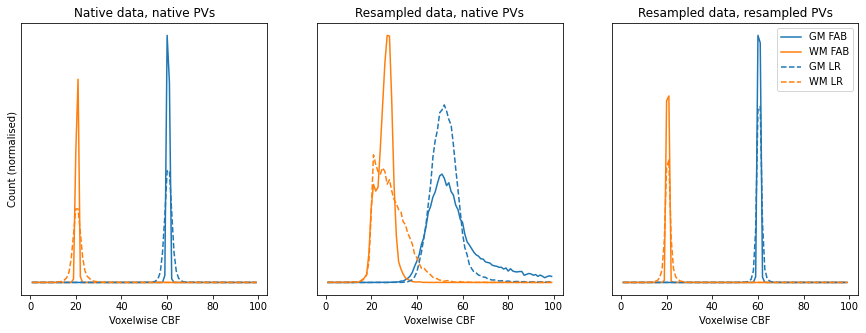

In [5]:
basil_native = load_basil(SIM_ROOT / 'basil_native')
basil_naive = load_basil(SIM_ROOT / 'basil_naive')
basil_resampled = load_basil(SIM_ROOT / 'basil_double_resampled')

lr_native = load_lr(SIM_ROOT / 'lr_native')
lr_naive = load_lr(SIM_ROOT / 'lr_naive')
lr_resampled = load_lr(SIM_ROOT / 'lr_double_resampled')

fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=False)
bins = np.arange(0, 100, 1)

for ax, data, title in zip(axes, [basil_native, basil_naive, basil_resampled],
                        ['Native data, native PVs', 'Resampled data, native PVs', 'Resampled data, resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_native, lr_naive, lr_resampled]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

LHS: The native space data, before resampling, and PVEc with the native PVs. Ground truth is clearly recovered for both methods. 

Center: Resampled data, PVEc with the native PVs. Both methods struggle. FABBER does a better job on WM but suffers on GM (it gives a positive skewed distribution, ie, there is a long tail on the high side). LR does a better job on GM but struggles on WM (again, there is a positive skew with a long tail on the high side). 

RHS: Resampled data, PVEc with resampled PVs. Both methods are able to recover ground truth. 

There are two conclusions: 
1. analysis in native space is preferred from the point of view of PVEc as this minimises the extent of PVE, thereby reducing the burden on PVEc. 
2. if resampling of data with PVE is required, then resampling the PV estimates in the same manner is a viable strategy (though as will be seen later, it doesn't always work perfectly). 

### Does the change in PV explain the change in CBF for resampled data?

The basic assumption underpinning PVEc is that raw CBF scales directly with the tissue PVs present in a voxel. This means that we expect a positive linear relationship between GM PV and raw CBF. Whilst it easy to establish this relationship in the original data (prior to resampling), what happens to it after resampling?

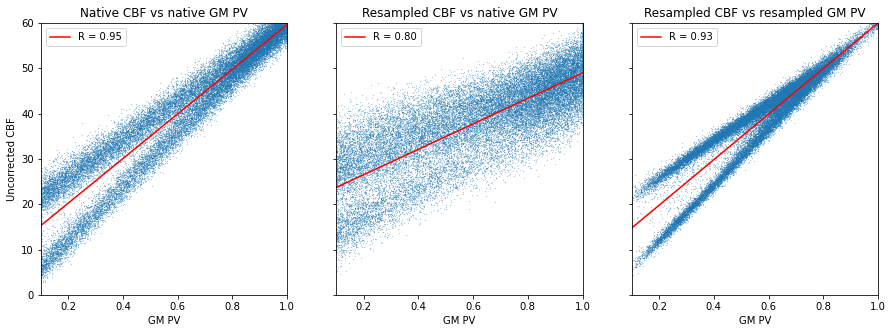

In [6]:
pvs_dbl = nibabel.load(str(SIM_ROOT / 'pvs_resampled.nii.gz')).get_fdata()
basil_native = load_basil(SIM_ROOT / 'basil_native', False)
basil_naive = load_basil(SIM_ROOT / 'basil_naive', False)

fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
for ax,x,y,t in zip(axes, [pvs[...,0], pvs[...,0], pvs_dbl[...,0]], [basil_native, basil_resamp, basil_resamp],
                    ['Native CBF vs native GM PV', 'Resampled CBF vs native GM PV', 'Resampled CBF vs resampled GM PV']):
    ax.scatter(x[gmmask], y[gmmask], s=0.02)
    reg = stats.linregress(x[gmmask], y[gmmask])
    ax.plot([0, 1], [reg.intercept, reg.intercept+reg.slope], label=f'R = {reg.rvalue:.02f}', c='r')
    ax.set_xlim(0.1,1)
    ax.legend()
    ax.set_title(t)
    ax.set_xlabel('GM PV')
    ax.set_ylim(0,60)
    
axes[0].set_ylabel('Uncorrected CBF')
plt.show()

LHS: scatter plot of GM PV vs raw CBF. The two lines represent two classes of mixed voxels (the upper one is mixed WM / GM, the other is mixed GM / CSF). A linear regression gives an R value (correlation coefficient) of 0.95, ie, the GM PV explains almost all variation in CBF. 

Central: raw CBF from resampled data vs un-resampled PVs (the naive PVEc). The linear regression now has an R value of 0.8; the un-resampled PVs do a worse job of explaining the variation in CBF. 

RHS: raw CBF from resampled data vs resampled PVs (the double resampling PVEc). This is the same CBF data as the central plot. The linear regression now has an R value of 0.93; the resampled PVs better explain the variation in CBF compared to the naive case. Interestingly, the variance of the bimodal distribution is somewhat reduced compared to the LHS case; this is most likely because the resampling reduces the influence of the white noise that was present in the data (ie, we've done a little bit of smoothing and this has reduced noise). 

Taken together, these plots show that double resampled PVs correlate better with uncorrected CBF than the naive PVs; ie, they do a better job of explaning the observed variations. Therefore, it is reasonable to conclude that this justifies their use for PVEc of resampled data. 

### What happens to the voxels that suffer most from resampling?

Clearly, not all voxels will be affected in the same way by resampling. Voxels near edges will suffer greater signal mixing. Can we correlate the changes seen in the double resampled PV map with the changes seen in un-corrected CBF on the resampled data?

We calculate the change in CBF as the voxelwise difference: raw CBF from resampled data - raw CBF from original data. Change in GM PV is the difference: GM PV in double-resampled estimates - GM PV in original estimates 

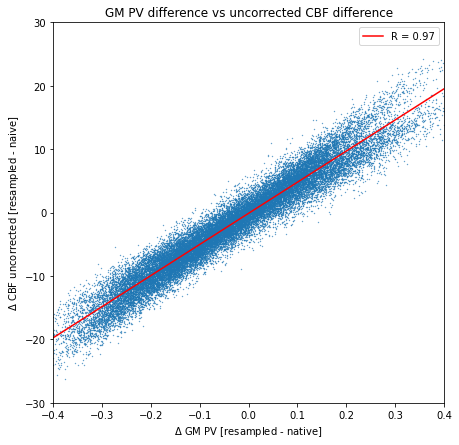

In [7]:
fig = plt.figure(figsize=(7,7))
delta_gm = (pvs_dbl - pvs)[gmmask,0]
delta_cbf = (basil_resamp - basil_native)[gmmask]
plt.scatter(delta_gm, delta_cbf, s=0.1)
reg = stats.linregress(delta_gm, delta_cbf)
plt.plot([-1, 1], [reg.intercept-reg.slope, reg.intercept+reg.slope], label=f'R = {reg.rvalue:.02f}', c='r')
plt.xlim(-0.4, 0.4)
plt.title('GM PV difference vs uncorrected CBF difference')
plt.ylim(-30,30)
plt.legend()
plt.ylabel(r'$\Delta$ CBF uncorrected [resampled - naive]')
plt.xlabel(r'$\Delta$ GM PV [resampled - native]')
plt.show()

Scatter plot of change in CBF vs change in PV. The linear regression is very strong (R value 0.97); the change in PV introduced into the PV estimates by resampling explains almost all the change seen when resampling the corresponding CBF map. 

## Simulated repeat data with high noise, common space analysis

The findings from the above experiment have practical implications for the analysis of repeat acquisition data. In particular, given a set of N un-registered acquisitions, each in their own native space, is it possible to perform voxel-wise analysis on a common template without falling foul of the resampling problem?

Because the subject may have moved slightly in between acquisitions, the distribution of PVEs within the data will be different on each. If we would like to remove this effect from the data then we will need to perform PVEc. Assuming we want to operate in the common space (eg, T1 ASL gridded space), whats the best way forwards?

The individual repeats are generated as follows:
1. generate a random transform and apply it to the common space PV estimates to get 'acquisition native PVs'
2. generate ASL data using these acquisition native PVs (with double the level of noise as before, to make things more realistic)
3. reverse transform the ASL data into common space to get the common aligned data (all will be co-registered)
4. reverse transform the acquisition native PVs to get 'double resampled' PVs. 
5. Estimate CBF on the common aligned data with two variants of PVEc: i) with the common space PV estimates ('naive') ii) with the double resampled PV estimates 

Step 5 is the slightly paradoxical bit: once all the data is in common alignment, in theory the only information required for PVEc of each repeat is the set of common space PV estimates. To be explicit, this involves correcting all the individual repeats using the same set of PV estimates. Given that we have applied the self-inverse of each transform, the repeats must all be in exactly the same alignment, and therefore there is only one anatomically correct set of PV estimates that could be used. In reality, we already know that the PVE in each native acquisition space were different to start with, so it follows that the PVE will still be different in the common aligned space. This is why the double-resampled PVs are useful: they convey information about the PVE that were present at the time the data was acquired, and this is what actually counts for successful PVEc. 

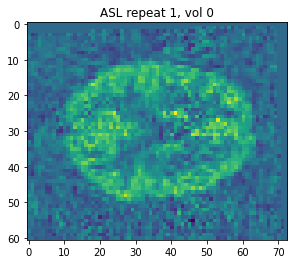

In [8]:
asl_rpt = loadnii(SIM_ROOT / f'asl_rpt0_in_common.nii.gz')
plt.imshow(asl_rpt[...,30,0])
plt.title('ASL repeat 1, vol 0')
plt.show()

In [9]:
basil_naive_nocorr = []
basil_naive = [] 
basil_dbl = []
lr_naive = [] 
lr_dbl = [] 

for idx in range(N_REPEATS):
    basil_naive_nocorr.append(load_basil(SIM_ROOT / f'basil_rpt{idx}_naive', False))
    basil_naive.append(load_basil(SIM_ROOT / f'basil_rpt{idx}_naive'))
    basil_dbl.append(load_basil(SIM_ROOT / f'basil_rpt{idx}_double_resampled'))
    lr_naive.append(load_lr(SIM_ROOT / f'lr_rpt{idx}_naive'))
    lr_dbl.append(load_lr(SIM_ROOT / f'lr_rpt{idx}_double_resampled'))
    
basil_naive_nocorr = np.stack(basil_naive_nocorr, axis=-1)
basil_naive = np.stack(basil_naive, axis=-1)
basil_dbl = np.stack(basil_dbl, axis=-1)
lr_naive = np.stack(lr_naive, axis=-1)
lr_dbl = np.stack(lr_dbl, axis=-1)

### PVEc in common space after resampling 

In common space, does PVEc function well in aggregate?

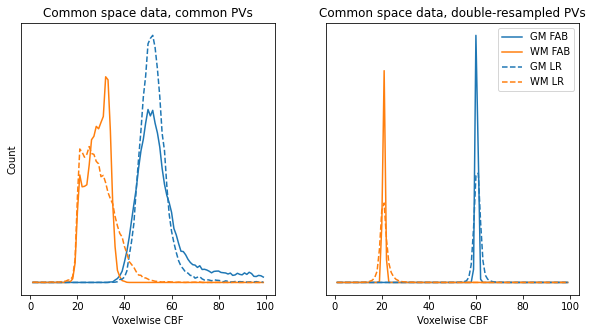

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=False)
bins = np.arange(0, 100, 1)

for ax, data, title in zip(axes, [basil_naive, basil_dbl],
                        ['Common space data, common PVs', 'Common space data, double-resampled PVs']):
    h, _ = np.histogram(data.mean(-1)[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data.mean(-1)[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_naive, lr_dbl]):
    h, _ = np.histogram(data.mean(-1)[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data.mean(-1)[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

LHS: PVEc using the common space PVs. Similar trends are observed as in the low-noise simulation case; FABBER has a positive skew for GM and does better for WM; LR vice-versa. 

RHS: PVEc using the double resampled PVs; both methods are able to recover ground truth. 

In both cases, the mean distribution across all 4 repeat acquisitions is shown. 

### Does PVEc improve the repeatability of CBF measurement? 

In theory, PVEc removes a dependency between structure and CBF measurment from the data, and this should improve the repeatability of CBF measurements. This is particularly the case for repeat data where the PVs will be slighly different in between each native acquisition (and our simplified simulations with constant CBF should further support this). Because we are mapping all the data into a single common analysis space, we can perform voxel-wise evaluations of CoV in the following manner: 

1. Various ROIs based on PV thresholds are defined in the common space *using the naive PV map*. The objective here isn't to identify voxels with a genuinely similar levels of PVs (because to do so we would need to use the double resampled PV maps from each acquisition, but these will all be different). Instead, we simply want to get a set of voxels that are spatially consistent between all runs (because they are all coregistered). So although the ROIs are based on PV thresholds, in reality the exact PV values themselves are only approximate, the real point is to define a set of voxels that are consistently located in space across all runs. 
2. Within ROIs, CoV is calculated as follows: std( voxel-wise CBF across runs ) / mean( voxelwise CBF across runs ). This gives a CoV value for each voxel in the ROI; the average across the ROI is then taken. 

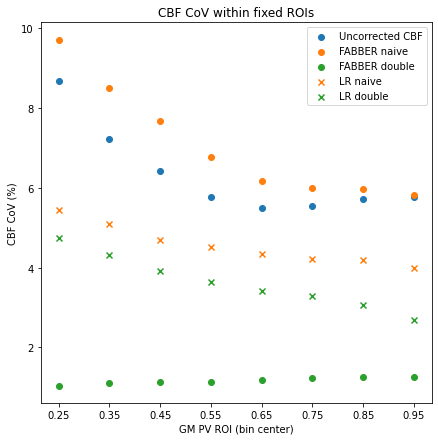

In [11]:
pvs = loadnii(SIM_ROOT / 'tob_all_stacked_3.0.nii.gz')
step = 0.1
lows = np.arange(0.2, 1.0, step)

fig = plt.figure(figsize=(7,7))

for low in lows:
    high = low + step 
    pvmask = (pvs[...,0] >= low) & (pvs[...,0] < high)
    
    for idx,data in enumerate([basil_naive_nocorr, basil_naive[...,0,:], basil_dbl[...,0,:]]):
        samples = data[pvmask]
        cov = 100 * (samples.std(1) / samples.mean(1)).mean()
        plt.scatter(low + step/2, cov, color=cmap[idx,:])
        
    for idx,data in enumerate([lr_naive[...,0,:], lr_dbl[...,0,:]]):
        samples = data[pvmask]
        cov = 100 * (samples.std(1) / samples.mean(1)).mean()
        plt.scatter(low + step/2, cov, color=cmap[idx+1,:], marker='x')           
        
plt.xticks(lows + step/2)
plt.ylabel('CBF CoV (%)')
plt.xlabel('GM PV ROI (bin center)')
plt.title('CBF CoV within fixed ROIs')
plt.legend(['Uncorrected CBF', 'FABBER naive', 'FABBER double', 'LR naive', 'LR double'])
plt.show()

Uncorrected CBF shows decreasing CoV with increasing GM PV. This is fairly logical, as voxels tend towards pure GM then their SNR increases and getting an accurate CBF estimate is easier. At lower GM PV, the remaining space may contain either WM or CSF; the overall voxel CBF will be very different in either case. This perhaps explains, alongside reduced SNR, the increased CoV seen for low GM PV. 

Looking at naive PVEc (using the un-resampled PV estimates), Fabber actually returns higher CoV than no PVEc, whereas LR returns lower. It's already been established that LR tends to do more smoothing so the reduced CoV compared to Fabber makes sense. Fabber's result can probably be explained by a combination of i) we know that naive PVs are not good for PVEc, and ii) PVEc amplifies signal, so perhaps amplifies noise (although the CoV metric should scale for this somewhat). 

For PVEc with double resampled PVs, both methods return lower CoV. For LR, the difference is marginal (probably because LR is a fairly consistent method, ie, most of its success derives from smoothing and therefore a small improvement in PV accuracy doesn't add much value). The improvement with Fabber is much larger, and in fact results in consistent CoV across the board. Qualitatively, we could perhaps argue that Fabber is able to utilise the extra accuracy of the double resampled PV estimates to implement its smoothing in a manner that is supported by the data, hence giving consistent results. 

Conclusion so far: PVEc does not necessarily reduce CoV for repeat analysis in a common space, though using the double-resampling strategy is the best way to go about it. 

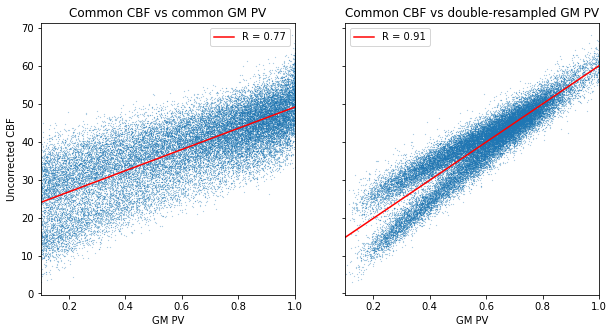

In [12]:
pvs_dbl = loadnii(SIM_ROOT / 'pvs_rpt0_double_resampled.nii.gz')
pvs = loadnii(SIM_ROOT / 'tob_all_stacked_3.0.nii.gz')
basil_naive = load_basil(SIM_ROOT / 'basil_rpt0_naive', False)
gmmask = pvs[...,0] > 0.1

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax,x,y,t in zip(axes, [pvs[...,0], pvs_dbl[...,0]], [basil_naive, basil_naive],
                    ['Common CBF vs common GM PV', 'Common CBF vs double-resampled GM PV']):
    ax.scatter(x[gmmask], y[gmmask], s=0.02)
    reg = stats.linregress(x[gmmask], y[gmmask])
    ax.plot([0, 1], [reg.intercept, reg.intercept+reg.slope], label=f'R = {reg.rvalue:.02f}', c='r')
    ax.set_xlim(0.1,1)
    ax.legend()
    ax.set_title(t)
    ax.set_xlabel('GM PV')
    
axes[0].set_ylabel('Uncorrected CBF')
plt.show()

This is a repeat of a plot shown earlier, establishing the relationship between GM PV and raw CBF, but this time in the presence of twice as much noise as before. The R-value holds up well even amongst noise, and it is stronger for the double-resampled PVs. 

## Maastricht data: single acquisition, low noise 

The same set of experiments, this time performed using real data from Maastricht. 

The data is 200 volumes of single TI pASL at 3mm isotropic, so relatively high SNR compared to typical ASL. There's only partial coverage of the brain so it doesn't pick up a huge amount of the cortex. The standard ATTs of 1.3 / 1.6s for GM / WM were used for analysis. 

In [13]:
mask = nibabel.load(str(REAL_ROOT / 'native/sub-SS_run-01_scale-2_space-native_mask.nii.gz')).get_fdata()
gm = nibabel.load(str(REAL_ROOT / 'native/sub-SS_run-01_scale-2_space-native_pvgm_tob.nii.gz')).get_fdata() 
wm = nibabel.load(str(REAL_ROOT / 'native/sub-SS_run-01_scale-2_space-native_pvgm_tob.nii.gz')).get_fdata() 

In [14]:
mask = binary_erosion(mask)
gmmask = (gm > 0.05) & mask
wmmask = (wm > 0.05) & mask

In [15]:
basil_native = load_oxasl(REAL_ROOT / 'native/basil_native', False)
basil_resamp = load_oxasl(REAL_ROOT / 'native/basil_resampled', False)
basil_double = load_oxasl(REAL_ROOT / 'native/basil_double')

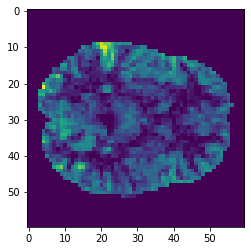

In [16]:
plt.imshow(basil_native[...,7])

## Resampling introduces PVE

Confirming the simulation result: resampling increases the PVE within the data. 

We take the data on a round-trip projection, as well as the PV estimates, and will subsequently perform PVEc on it 

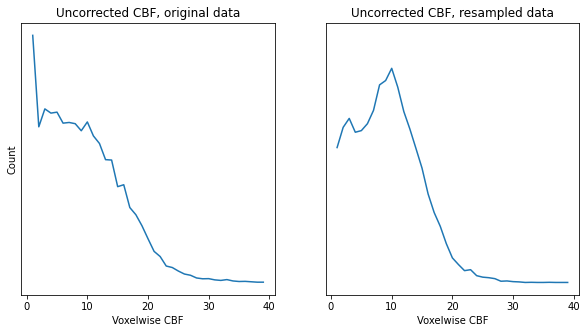

In [17]:
bins = np.arange(0,40,1)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, data, title in zip(axes, [basil_native, basil_resamp], 
                           ['Uncorrected CBF, original data', 'Uncorrected CBF, resampled data']):
    hist, _ = np.histogram(data[mask], bins)
    ax.plot(bins[1:], hist)
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
axes[0].set_ylabel('Count')
plt.show()

The challenge of working with real data is immediately apparent: the distributions aren't even close to being bi-modal as they were in the simulation case. The fact that almost all voxels have less than 30 units of CBF shows the extent of PVE in the data (although this figure will of course be very sensitive to the choice of ATT used during analysis). At any rate, the extra PVE introduced by resampling is readily observed: the peak of the distribution shifts to around 10 units. 

### Can PVEc undo the damage imposed by resampling? 

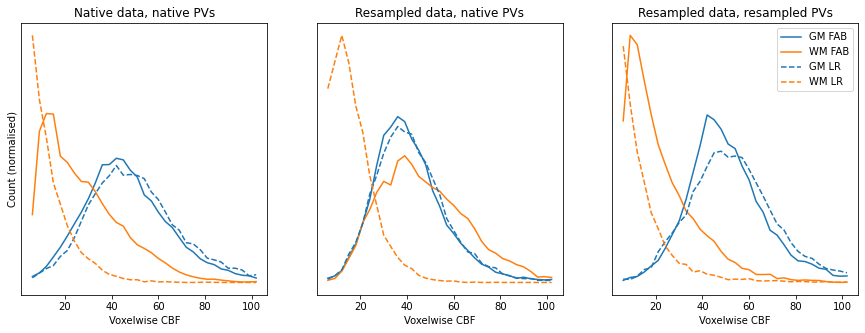

In [18]:
basil_native = load_oxasl(REAL_ROOT / 'native/basil_native')
basil_resamp = load_oxasl(REAL_ROOT / 'native/basil_resampled')
basil_double = load_oxasl(REAL_ROOT / 'native/basil_double')

lr_native = load_oxasl_lr(REAL_ROOT / 'native/lr_native')
lr_resamp = load_oxasl_lr(REAL_ROOT / 'native/lr_resampled')
lr_double = load_oxasl_lr(REAL_ROOT / 'native/lr_double')

fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=False)
bins = np.arange(3, 105, 3)

for ax, data, title in zip(axes, [basil_native, basil_resamp, basil_double],
                        ['Native data, native PVs', 'Resampled data, native PVs', 'Resampled data, resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_native, lr_resamp, lr_double]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

Note all results are masked to consider only voxels that contain the tissue in question. 

LHS: PVEc with native data and native PVs. This establishes what the 'ground truth' distributions of GM and WM CBF in the absence of any further processing. 

Central: PVEc with resampled data and native PVs. For both LR and Fabber, the distributions have clearly converged relative to the native case. This is especially true for Fabber WM, which in fact shows an even greater positive skew than Fabber GM (implying WM CBF is higher than GM CBF for many voxels). 

RHS: PVEc with resampled data and resampled PVs. The shape of the distributions is much closer to the original base case (LHS); if anything the distributions on fabber are arguably a bit tighter. This is likely due to the smoothing imposed by resampling increasing SNR. 

### Does the change in PV explain the change in CBF after resampling?

Scatter plots and linear regressions to establish the relationship between GM PV and raw CBF for this data. Does GM PV explain the variation in the data, and what happens to this relationship after resampling?

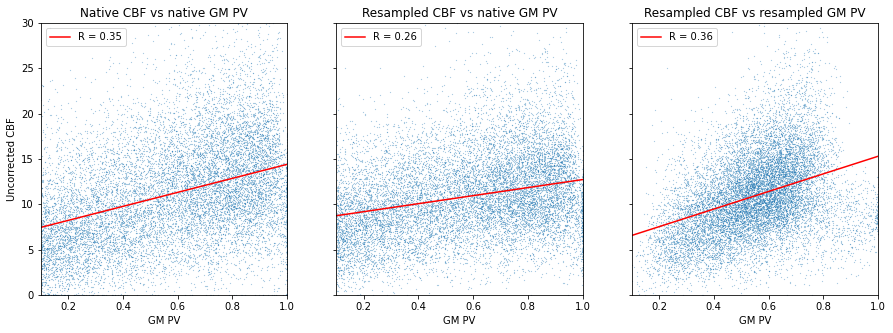

In [19]:
basil_native = load_oxasl(REAL_ROOT / 'native/basil_native', False)
basil_resamp = load_oxasl(REAL_ROOT / 'native/basil_resampled', False)
gm_dbl = loadnii(REAL_ROOT / 'native/pvgm_resamp.nii.gz')
gmmask = (gm > 0.1) & mask

fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
for ax,x,y,t in zip(axes, [gm, gm, gm_dbl], [basil_native, basil_resamp, basil_resamp],
                    ['Native CBF vs native GM PV', 'Resampled CBF vs native GM PV', 'Resampled CBF vs resampled GM PV']):
    ax.scatter(x[gmmask], y[gmmask], s=0.02)
    reg = stats.linregress(x[gmmask], y[gmmask])
    ax.plot([0, 1], [reg.intercept, reg.intercept+reg.slope], label=f'R = {reg.rvalue:.02f}', c='r')
    ax.set_xlim(0.1,1)
    ax.legend()
    ax.set_title(t)
    ax.set_xlabel('GM PV')
    ax.set_ylim(0,30)
    
axes[0].set_ylabel('Uncorrected CBF')
plt.show()

LHS: native raw CBF vs native GM PV; establishing the relationship in the base case. The effect of noise is clearly seen; although the relationship does exist, the R value is much smaller becuase PVs are not able to explain all the variation seen in data. 

Central: resampled raw CBF vs native GM PV. The R value decreases by ~0.1 compared to the base case; the native PVs are less able to explain the variation in CBF. The gradient is also reduced. 

RHS: resampled raw CBF vs resampled GM PV. The R value and gradient attain close to their original values from the base case again, demonstrating that the double resampled PVs do a better job of explaining the data, **even in the presence of high noise** and presumed underlying biological variability. 

### Analysis in a common space

Though we don't have repeats of this data, we can nevertheless choose to analyse it in a common space. We use ASL gridded T1 space here. In this framework, 'naive' PVs refers to those estimated directly from the T1 *without any transformation* (because we are transforming the data into alignment with the T1). Double resampled PVs referes to those estimated in alignment with the raw data, and then *transformed back into alignment with the T1*, using the same transform as that applied to the data. 

In [20]:
mask = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_mask.nii.gz')).get_fdata()
gm = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_pvgm_tob.nii.gz')).get_fdata() 
wm = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_pvwm_tob.nii.gz')).get_fdata() 

mask = binary_erosion(mask)
gmmask = (gm > 0.05) & mask
wmmask = (wm > 0.05) & mask

In [21]:
basil_naive = load_oxasl(REAL_ROOT / 'common/basil_naive')
basil_dbl = load_oxasl(REAL_ROOT / 'common/basil_double')
lr_naive = load_oxasl_lr(REAL_ROOT / 'common/lr_naive')
lr_dbl = load_oxasl_lr(REAL_ROOT / 'common/lr_double')

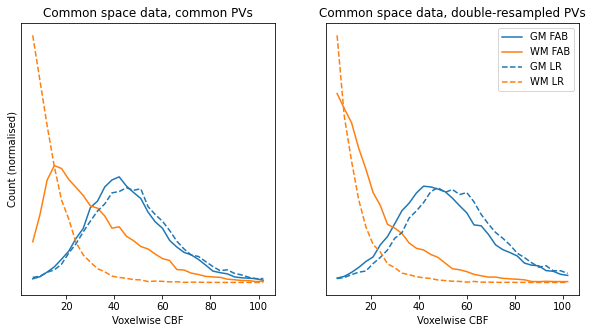

In [22]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=False)
bins = np.arange(3, 105, 3)

for ax, data, title in zip(axes, [basil_naive, basil_dbl],
                        ['Common space data, common PVs', 'Common space data, double-resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_naive, lr_dbl]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

LHS: PVEc of common-space data with naive PVs. Once again, relative to the base case established earlier in native space, the distributions have converged (especially Fabber WM). 

RHS: PVEc of common-space data with double resampled PVs. Clearer separation is seen between the respective tissue distributions; we can judge this to be more similar to the native space base case and therefore say double-resampled PVs are more appropriate for PVEc in a common analysis space. 

### Does the change in PV explain the change in CBF after resampling?


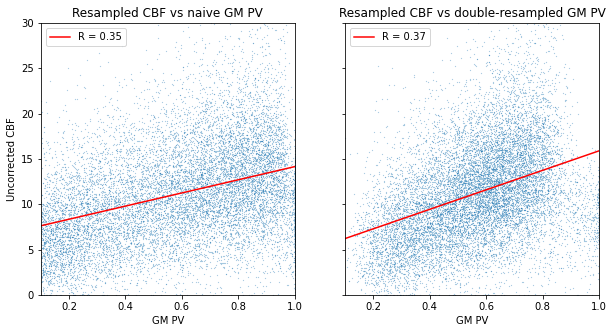

In [23]:
basil_naive = load_oxasl(REAL_ROOT / 'common/basil_naive', False)
gmd = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_pvgm_tob.nii.gz')).get_fdata() 
gmc = nibabel.load(str(REAL_ROOT / 'common/sub-SS_scale-2_space-common_pvgm_tob_naive.nii.gz')).get_fdata() 
gmmask = (gmc > 0.1) & mask 

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax,x,y,t in zip(axes, [gmc, gmd], [basil_naive, basil_naive],
                    ['Resampled CBF vs naive GM PV', 'Resampled CBF vs double-resampled GM PV']):
    ax.scatter(x[gmmask], y[gmmask], s=0.02)
    reg = stats.linregress(x[gmmask], y[gmmask])
    ax.plot([0, 1], [reg.intercept, reg.intercept+reg.slope], label=f'R = {reg.rvalue:.02f}', c='r')
    ax.set_xlim(0.1,1)
    ax.legend()
    ax.set_title(t)
    ax.set_xlabel('GM PV')
    ax.set_ylim(0,30)
    
axes[0].set_ylabel('Uncorrected CBF')
plt.show()

LHS: resampled data, raw CBF, vs naive GM PV. 

RHS: resampled data, raw CBF, vs double resampled GM PV. 

The gradient of the relationship is greater for the latter case, and the R value is ever so slightly higher (though marginal at best). This suggests that although the double resampled PVs better explain the data, there remain many other effects at work (and much noise) and therefore the difference is slight. 

## Maastricht repeat data, low SNR 

Same acquisition as before, but of a different subject with 3 repeat acquisitions of 100 volumes each (half the number of before). I've exluded one run (there were 4 originally) because it is clearly an outlier for all methods. 

We have transformed all repeats into common aligned analysis space (T1 asl grid) and measure CoV across repeats using the same approach as in the simulations. The basis of defining on ROIs using thresholds on the *naive PV estimates* is retained, though again these PV ROIs do not necessarily reflect the true PVs of the underlying data, they simply refer to spatially consistent locations in the brain. 

In [24]:
basil_naive_nocorr = []
basil_naive = [] 
basil_dbl = []
lr_naive = [] 
lr_dbl = [] 

from pathlib import Path 
REAL_ROOT = Path('/mnt/hgfs/Data/pvec_problems/maastricht-02/common')

for idx in range(3):
    basil_naive_nocorr.append(load_oxasl(REAL_ROOT / f'basil_naive_rpt{idx+1}', False))
    basil_naive.append(load_oxasl(REAL_ROOT / f'basil_naive_rpt{idx+1}'))
    basil_dbl.append(load_oxasl(REAL_ROOT / f'basil_double_rpt{idx+1}'))
    lr_naive.append(load_oxasl_lr(REAL_ROOT / f'lr_naive_rpt{idx+1}'))
    lr_dbl.append(load_oxasl_lr(REAL_ROOT / f'lr_double_rpt{idx+1}'))
    
basil_naive_nocorr = np.stack(basil_naive_nocorr, axis=-1)
basil_naive = np.stack(basil_naive, axis=-1)
basil_dbl = np.stack(basil_dbl, axis=-1)
lr_naive = np.stack(lr_naive, axis=-1)
lr_dbl = np.stack(lr_dbl, axis=-1)
gm = loadnii(REAL_ROOT / 'sub-02_scale-2_space-common_pvgm_tob_naive.nii.gz')
mask = loadnii(REAL_ROOT / 'sub-02_run-01_scale-2_space-common_mask.nii.gz')
mask = binary_erosion(mask)

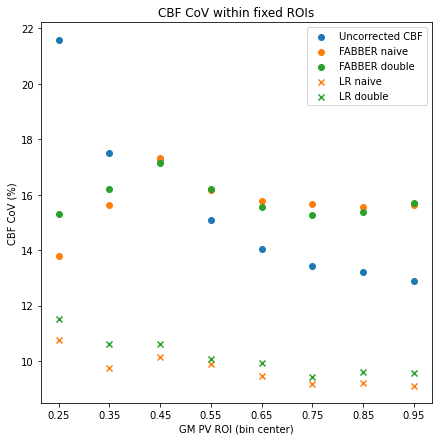

In [25]:
step = 0.1
lows = np.arange(0.2, 1.0, step)

fig = plt.figure(figsize=(7,7))

for low in lows:
    high = low + step 
    pvmask = (gm >= low) & (gm < high) & mask
    
    for idx,data in enumerate([basil_naive_nocorr, basil_naive[...,0,:], basil_dbl[...,0,:]]):
        samples = data[pvmask]
        samples = samples[(samples > 1).any(1),:]
        cov = 100 * (samples.std(1) / samples.mean(1)).mean()
        plt.scatter(low + step/2, cov, color=cmap[idx,:])
        
    for idx,data in enumerate([lr_naive[...,0,:], lr_dbl[...,0,:]]):
        samples = data[pvmask]
        samples = samples[(samples > 1).any(1),:]
        cov = 100 * (samples.std(1) / samples.mean(1)).mean()
        plt.scatter(low + step/2, cov, color=cmap[idx+1,:], marker='x')           
        
plt.xticks(lows + step/2)
plt.ylabel('CBF CoV (%)')
plt.xlabel('GM PV ROI (bin center)')
plt.title('CBF CoV within fixed ROIs')
plt.legend(['Uncorrected CBF', 'FABBER naive', 'FABBER double', 'LR naive', 'LR double'])
plt.show()

In keeping with the simulations, uncorrected CBF shows decreasing CoV for increasing GM PV (increasing SNR with increased GM PV etc). 

The LR method returns lower CoV for both variants of PVEc in all ROIs, though the difference between the two variants is essentially non-existent. This is in keeping with the simulation results which suggest that the LR method is fairly insensitive to a small change in PV estimates themselves, its value derives mainly from the high level of smoothing it imposes. 

Fabber's results are more complex. Though it does return lower CoV than no PVEc for low GM PV thresholds, above 50% PV it actually returns a higher CoV than no PVEc. At the very highest PVs, this could be due to the signal and noise amplification that accompanies PVEc (ie, everything gets bigger). 

There is a very important caveat with these results. In the simulation case, we targeted CoV because we knew that all CBF within tissue classes was constant to begin with. In this case, we do not know the underlying variability of GM CBF in-vivo, and this therefore sets a floor on what value of CoV would be 'correct'. Put another way, if a method did manage to return 0% CoV, that may not actually be correct as it might ignore natural variability in CM CBF.

In conclusion to the question does PVEc reduce CoV for repeat analysis in a common space, we can't give a clear answer. Clearly, FABBER struggles in a high-noise situation more than it does with low-noise data. LR gives very consistent results, but that arguably arises mainly due to it imposing the strong assumption of constant CBF than really reflecting whats going on in the data. One partial success we can claim for PVEc is this: in the absence of PVEc, the CoV of CBF measurement is a function of GM PV. I think this arises due to low SNR at low PV, and also the ambiguity of mixed GM/WM vs mixed GM/CSF voxels (they will have very different signal intensities). PVEc with either method does at least lead to more consistent CoV for all PV ROIs, ie, it reduces the relationship between CoV and GM PV. Whilst this isn't the same as saying it *reduces* CoV for all voxels, it does give more *consistent* CoV across voxels.  

This conclusion doesn't agree so well with some of the ASL PVEc literature (which has sometimes emphasised repeatability as the main benefit), but it does agree with some of the PET PVEc literature, which actually reported PVEc as increasing inter-subject variability in a manner that was held to be genuine. 